In [4]:
import torch
import numpy as np
from matplotlib import pyplot as plt
import random

## 1.生成数据集

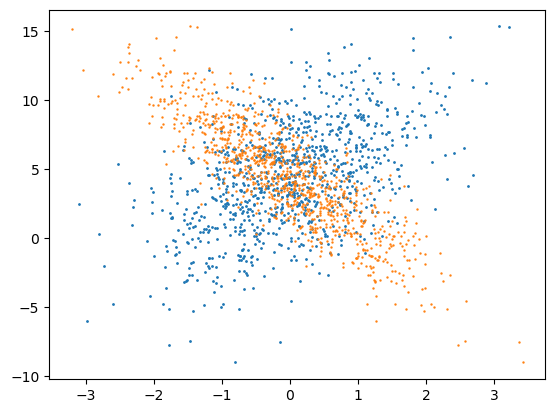

In [26]:
num_inputs = 2
num_features = 1000
true_w = [2,-3.4]
true_b = 4.2
features = torch.randn(num_features,num_inputs,dtype=torch.float32)
labels = true_w[0]*features[:,0] + true_w[1]*features[:,1] + true_b
labels += torch.tensor(np.random.normal(0,0.01,size=labels.size())
                      ,dtype=torch.float32)
plt.scatter(features[:,0].numpy(),labels.numpy(),1)
plt.scatter(features[:,1].numpy(),labels.numpy(),0.5)

通过生成第二个特征features[:, 1]和标签 labels 的散点图，可以更直观地观察两者间的线性关系。

## 2.读取数据

在训练模型的时候，我们需要遍历数据集并不断读取小批量数据样本。这里我们定义一个函数：它每次返回batch_size（批量大小）个随机样本的特征和标签。

In [54]:
def data_iter(batch_size,features,labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    random.shuffle(indices)
    for i in range(0,num_examples,batch_size):
        j = torch.LongTensor(indices[i:min(i+batch_size,num_examples)])
        yield features.index_select(0,j),labels.index_select(0,j)

让我们读取第一个小批量数据样本并打印。每个批量的特征形状为(10, 2)，分别对应批量大小和输入个数；标签形状为批量大小。

In [55]:
batch_size = 10
for X,y in data_iter(batch_size,features,labels):
    print(X,y)
    break

tensor([[ 0.7162,  1.6251],
        [-0.3818, -0.7472],
        [ 0.9050,  0.4601],
        [ 0.3735, -0.7149],
        [-0.0479, -1.6541],
        [-1.0872, -0.8906],
        [ 0.8838,  0.9723],
        [-0.6883, -1.0081],
        [-0.2340, -1.8559],
        [ 1.3299, -0.3888]]) tensor([ 0.1120,  5.9781,  4.4563,  7.3786,  9.7336,  5.0536,  2.6506,  6.2582,
        10.0544,  8.1934])


## 3.初始化模型参数

我们将权重初始化成均值为0、标准差为0.01的正态随机数，偏差则初始化成0。

In [58]:
w = torch.tensor(np.random.normal(0,0.01,(num_inputs,1)),
                dtype=torch.float32)
b = torch.zeros(1,dtype=torch.float32)

之后的模型训练中，需要对这些参数求梯度来迭代参数的值，因此我们要让它们的requires_grad=True。

In [60]:
w.requires_grad_(requires_grad=True)
b.requires_grad_(requires_grad=True) 

tensor([0.], requires_grad=True)

## 4.定义模型

下面是线性回归的矢量计算表达式的实现。我们使用mm函数做矩阵乘法。

In [ ]:
def linreg(X,w,b):
    return torch.mm(X,w)+b

## 5.定义损失函数

我们使用上一节描述的平方损失来定义线性回归的损失函数。在实现中，我们需要把真实值y变形成预测值y_hat的形状。以下函数返回的结果也将和y_hat的形状相同。

In [ ]:
def squared_loss(y_hat,y):
    return (y_hat - y.view(y_hat.size())) ** 2 / 2

## 6.定义优化算法

以下的sgd函数实现了上一节中介绍的小批量随机梯度下降算法。它通过不断迭代模型参数来优化损失函数。这里自动求梯度模块计算得来的梯度是一个批量样本的梯度和。我们将它除以批量大小来得到平均值。

In [61]:
def sgd(params,lr,batch_size):
    for param in prarams:
        param.data -= lr * param.grad / batch_size

## 7.训练模型

在训练中，我们将多次迭代模型参数。在每次迭代中，我们根据当前读取的小批量数据样本（特征X和标签y），通过调用反向函数backward计算小批量随机梯度，并调用优化算法sgd迭代模型参数。由于我们之前设批量大小batch_size为10，每个小批量的损失l的形状为(10, 1)。回忆一下自动求梯度一节。由于变量l并不是一个标量，所以我们可以调用.sum()将其求和得到一个标量，再运行l.backward()得到该变量有关模型参数的梯度。注意在每次更新完参数后不要忘了将参数的梯度清零。

在一个迭代周期（epoch）中，我们将完整遍历一遍data_iter函数，并对训练数据集中所有样本都使用一次（假设样本数能够被批量大小整除）。


这里的迭代周期个数num_epochs和学习率lr都是超参数，分别设3和0.03。

在实践中，大多超参数都需要通过反复试错来不断调节。虽然迭代周期数设得越大模型可能越有效，但是训练时间可能过长。而有关学习率对模型的影响，我们会在后面“优化算法”一章中详细介绍。

In [ ]:
lr = 0.03
num_epochs = 3
net = linreg
loss = squared_loss

for epoch in range(num_epochs):# 训练模型一共需要num_epochs个迭代周期
    # 在每一个迭代周期中，会使用训练数据集中所有样本一次（假设样本数能够被批量大小整除）。X
    # X和y分别是小批量样本的特征和标签
    for X,y in data_iter(batch_size,features,labels):
        # l是有关小批量X和y的损失
        l = loss(net(X, w, b), y).sum()
        # 小批量的损失对模型参数求梯度
        l.backward()
        # 使用小批量随机梯度下降迭代模型参数
        sgd([w, b], lr, batch_size)
        
        # 不要忘了梯度清零
        w.grad.data.zero_()
        b.grad.data.zero_()